In [1]:
import os
import sys
sys.path.append('..')
from util import db_io
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
con = sqlite3.connect('db/telemetry.db', detect_types=sqlite3.PARSE_DECLTYPES)
cursor = con.cursor()
def read_df_none(con):
    df = pd.read_sql_query('SELECT timestamp, type, value FROM telemetry', con,
                               index_col='timestamp')
    return df
print "No datetime conversion"
%timeit read_df_none(con)

def read_df_pd(con):
    df = pd.read_sql_query('SELECT timestamp, type, value FROM telemetry', con,
                               index_col='timestamp',
                               parse_dates={'timestamp': {'unit': 's'}})
    
    df.tz_localize('UTC', copy=False) \
      .tz_convert('Europe/Amsterdam', copy=False)
    return df
print "datetime via sql_query"
%timeit read_df_pd(con)

# def read_df_iter(con):
#     pass
# %timeit read_df_iter(con)

def read_df_np(con):
    df = pd.read_sql_query('SELECT timestamp, type, value FROM telemetry', con)  #  WHERE id<1000000
    df.timestamp = df.timestamp.astype("datetime64[s]")
    df.set_index('timestamp', inplace=True)
    df.tz_localize('UTC', copy=False) \
      .tz_convert('Europe/Amsterdam', copy=False)
    return df
print "datetime via numpy"
%timeit read_df_np(con)

No datetime conversion
1 loops, best of 3: 1.09 s per loop
datetime via sql_query
1 loops, best of 3: 2.33 s per loop
datetime via numpy
1 loops, best of 3: 1.12 s per loop


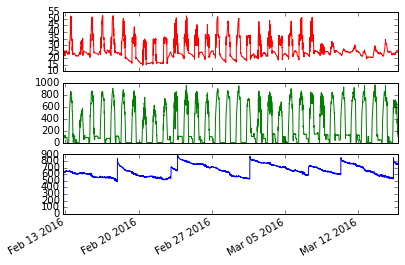

In [11]:
fig.autofmt_xdate(False)
df = read_df_np(con)
groups = df.groupby(['type']); groups.groups.keys()
color = ['r', 'g', 'b']
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
for n in range(3):
    groups.get_group(n+1)['value'].resample('6min').plot(ax=axes[n], style=color[n]);
    axes[n].set_xlabel('')

10 loops, best of 3: 84.7 ms per loop


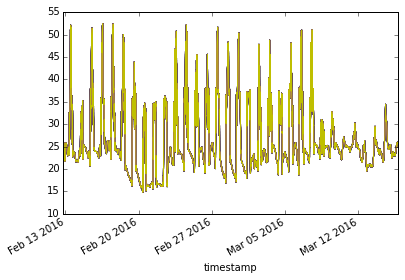

In [15]:
group = df.value.groupby(df['type']).get_group(1)
#slice = df.value.loc[df.type==1]
%timeit group.resample('6min').plot()
##%timeit slice.resample('6min').plot()

## Finding max and min values in timestamps
To get from np.datetime64 to something that can be sorted
The timestamps are just the unix time with nanoseconds, but
as integers.

For some reason, the sub-second part is lost.

In [43]:
# without conversion to datetime64
df = read_df_none(con)
%timeit max(df.index)

# With conversion to datetime64
df = read_df_np(con)
%timeit max(df.index)
%timeit max(df.index.astype(np.int64)/1e9)

10 loops, best of 3: 84.6 ms per loop
1 loops, best of 3: 3.05 s per loop
10 loops, best of 3: 88.7 ms per loop


In [42]:
## Doesnt: work
# df.index.astype(np.double)//1e9
## Does work:
%timeit df.index.astype(np.int64).astype(np.double)/1e9

%timeit df.index.astype(np.int64).astype(np.double)//1e9

%timeit df.index.astype(np.int64)/1e9


100 loops, best of 3: 4.49 ms per loop
100 loops, best of 3: 7.71 ms per loop
100 loops, best of 3: 3.91 ms per loop


In [10]:
from sqlalchemy import create_engine
# Create your connection.
engine = create_engine('sqlite:///../local/db/telemetry.db')

# --> Slower than simple sqlite3!

In [44]:
# NOTE: Raspberry might be IO bound, rather than CPU bound, when reading in
# uncompressed tables.

df = pd.read_sql_query('SELECT timestamp, type, value FROM telemetry', con)
df.timestamp = df.timestamp.astype("datetime64[s]")
print df.head(5)

def test_sql_write(df):
    if os.path.exists('../local/db/test.sql'):
        os.remove('../local/db/test.sql')
    with sqlite3.connect('../local/db/test.sql') as sql_db:
        df.to_sql(name='telemetry', con=sql_db)
    
def test_sql_read():
    with sqlite3.connect('../local/db/telemetry.db') as sql_db:
        df = pd.read_sql_query("select * from telemetry", sql_db)
    df.set_index('timestamp', inplace=True)

def test_hdf_fixed_write(df):
    df.to_hdf('../local/db/test_fixed.hdf','test',mode='w')

def test_hdf_fixed_read():
    df = pd.read_hdf('../local/db/test_fixed.hdf','test')
    df.set_index('timestamp', inplace=True)

def test_hdf_fixed_write_compress(df):
    df.to_hdf('../local/db/test_fixed_compress.hdf','test',mode='w',complib='blosc')

def test_hdf_fixed_read_compress():
    df = pd.read_hdf('../local/db/test_fixed_compress.hdf','test')
    df.set_index('timestamp', inplace=True)

print 'SQL'
%timeit test_sql_write(df)
%timeit test_sql_read()

print 'HDF'
%timeit test_hdf_fixed_write(df)
%timeit test_hdf_fixed_read()

print 'HDF_compressed'
%timeit test_hdf_fixed_write_compress(df)
%timeit test_hdf_fixed_read_compress()

            timestamp  type   value
0 2016-02-12 17:50:43     3     NaN
1 2016-02-12 17:50:43     2  116.00
2 2016-02-12 17:50:43     1   25.38
3 2016-02-12 17:50:48     3     NaN
4 2016-02-12 17:50:48     2  114.62
SQL
1 loops, best of 3: 6.06 s per loop
1 loops, best of 3: 1.4 s per loop
HDF
10 loops, best of 3: 179 ms per loop
100 loops, best of 3: 19.5 ms per loop
HDF_compressed
10 loops, best of 3: 143 ms per loop
10 loops, best of 3: 44.7 ms per loop
